In [11]:
# Standard imports

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [14]:
sys.path.append('../../')

In [15]:
# Local import

In [16]:
import continuum

In [17]:
# Load trained model from checkpoint

In [18]:
checkpoint_path = '../results/H/version_0/_ckpt_epoch_97.ckpt'
model = continuum.Model.load_from_checkpoint(checkpoint_path)

drift_fn = model.drift_fn
state = model.state

In [19]:
# Make plot

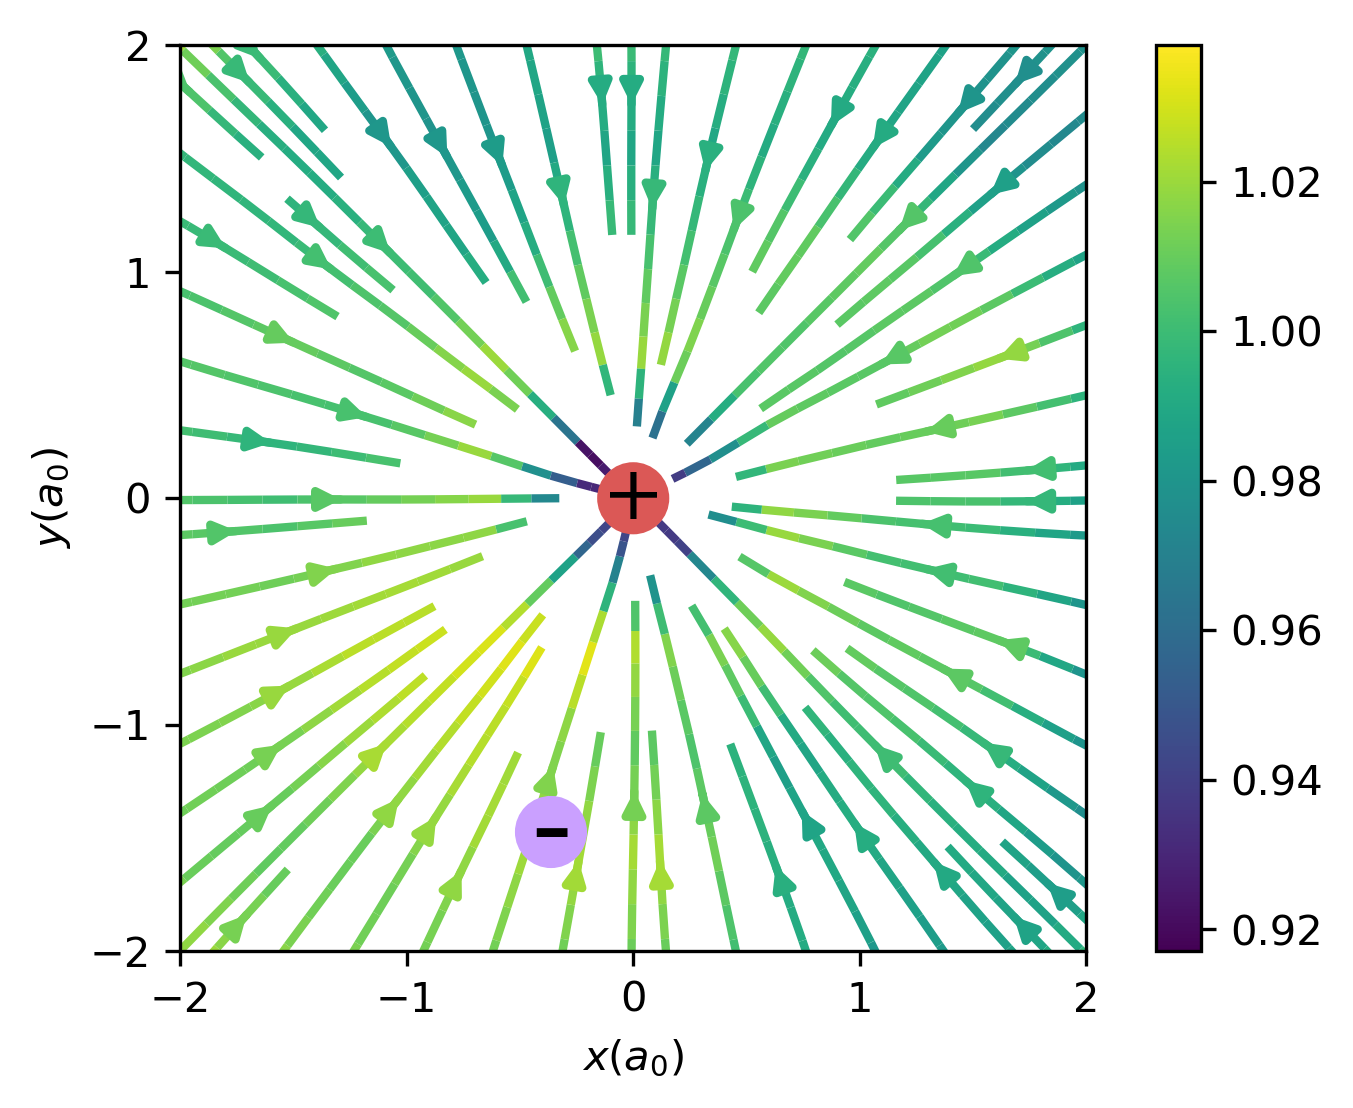

In [20]:
with torch.no_grad():
    fig, ax = plt.subplots(dpi = 300)
    
    # make meshgrid for vector field
    border = 2
    xmin, xmax, ymin, ymax = -border, border, -border, border
    overshoot = 1.05
    N = 10
    X, Y = (torch.linspace(overshoot*xmin, overshoot*xmax, N),
            torch.linspace(overshoot*ymin, overshoot*ymax, N))
    XX, YY = torch.meshgrid(X, Y)
    
    # make batch where electron's position is varied on z-plane
    n = np.random.randint(state.shape[0])
    states = state[n].repeat(N**2, 1, 1)
    states[:, 0, 0] = torch.reshape(XX, (1, N**2))[0]
    states[:, 0, 1] = torch.reshape(YY, (1, N**2))[0]
    states[:, 0, 2] = 0

    # compute drift vector field and reshape to meshgrid shape
    v = drift_fn(states)
    vXX = torch.reshape(v[:, 0, 0], (N, N))
    vYY = torch.reshape(v[:, 0, 1], (N, N))
    
    # plot vector field stream plot
    speed = np.sqrt(vXX**2 + vYY**2)
    strm = plt.streamplot(X.numpy(), Y.numpy(), vYY.numpy(), vXX.numpy(),
                   density=1, linewidth=2,
                   color=speed.numpy(), cmap='viridis', zorder=-1)
    plt.colorbar(strm.lines, ax=ax)
    
    # plot particle positions
    # plot electron
    particle = plt.Circle((state[n, 0, 0], state[n, 0, 1]),
                          0.15, color='xkcd:pastel purple', zorder=0)
    ax.add_artist(particle)
    plt.text(state[n, 0, 0], state[n, 0, 1], '-',
             fontsize=28, horizontalalignment='center', verticalalignment='center')
    # plot proton
    particle = plt.Circle((0, 0), 0.15, color='xkcd:pastel red', zorder=0)
    ax.add_artist(particle)
    plt.text(0, 0, '+',
             fontsize=18, horizontalalignment='center', verticalalignment='center')
    
    plt.xlabel(r'$x (a_0)$')
    plt.ylabel(r'$y (a_0)$')
    plt.yticks([-2, -1, 0, 1, 2])
    plt.xlim(-border, border)
    plt.ylim(-border, border)
    ax.set_aspect(aspect='equal')
#     plt.show()
    plt.savefig("hydrogen_vector_field.jpg", dpi=300)
    